In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.optimize as op
import pprint
import json
import dateutil.parser

pp = pprint.PrettyPrinter(indent=2)

def isiterable(q):
    try:
        _ = (a for a in q)
        return True
    except TypeError:
        return False

# utilidad
def plot(save, title, xlabel, ylabel, plot_fn, *args, **kwargs):
    if not save.endswith('.png'):
        save += '.png'
    plt.figure(figsize=(20,10))
    plt.tick_params(labelsize=20)
    plot_fn(*args, **kwargs)
    plt.title(title, fontsize=30)
    plt.xlabel(xlabel, fontsize=24)
    plt.ylabel(ylabel, fontsize=24)
    plt.savefig(save)
    plt.show()

From mongo

```python
import pymongo

# mongo client
mc = pymongo.MongoClient('mongodb://localhost:27018')

# dmc data
D = mc.dmc.data
dataset = sorted([d for d in D.find({})], key=lambda x: x['ts'])

# schema
dataset[0]
```

In [7]:
def load_meteo_data(fname):
    '''Carga archivo .json con información de meteorología,
    '''
    def de(e):
        e['ts'] = dateutil.parser.parse(e['ts'])
        e['hum_ts'] = dateutil.parser.parse(e['hum_ts'])
        e['prc_ts'] = dateutil.parser.parse(e['prc_ts'])
        e['tmp_ts'] = dateutil.parser.parse(e['tmp_ts'])
        e['wnd_ts'] = dateutil.parser.parse(e['wnd_ts'])
        return e
        
    with open(fname, 'r') as f:
        return [de(e) for e in json.load(f)]

# already sorted
dataset = load_meteo_data('meteo-data.json')

# schema
dataset[0]

{'_id': '5ba309a4dd5b6bb6f586885a',
 'ts': datetime.datetime(2013, 1, 1, 0, 0),
 'dev': 330007,
 'hum': 76.0,
 'hum_ts': datetime.datetime(2013, 1, 1, 0, 0),
 'prc': 0.0,
 'prc_ts': datetime.datetime(2013, 1, 1, 0, 0),
 'tmp': 17.4,
 'tmp_ts': datetime.datetime(2013, 1, 1, 0, 0),
 'wnd': 3.0,
 'wnd_dir': 230,
 'wnd_ts': datetime.datetime(2013, 1, 1, 0, 0),
 'valid': True}

In [8]:
from datetime import datetime, timedelta

def load_wildfires(filename):
    with open(filename) as f:
        wildfires = json.load(f)
    for w in wildfires:
        w['start'] = datetime.fromisoformat(w['start'])
    return sorted(wildfires, key=lambda x: x['start'])

wz1 = load_wildfires('wz1ext.json')
wz2 = load_wildfires('wz2ext.json')
wz3 = load_wildfires('wz3ext.json')

In [9]:
len(wz3)

436

In [10]:
def cause_code(cause):
    return cause[:cause.find('. ') + 1]

def cause_cmp(cause):
    M, m, p, _ = cause_code(cause).split('.')
    return int(M) * 1000 + int(m) * 100 + int(p)

def cause_is_legal(cause):
    return\
        cause.startswith('1.1.5.') or\
        cause.startswith('1.8.1.') or\
        cause.startswith('1.8.2') or\
        cause.startswith('1.8.14')

def cause_by_code(causes, code):
    for k in causes:
        if k.startswith(code):
            return causes[k]
    raise KeyError

# wz1 < wz2 < wz3
causes = {}
for w in wz3:
    if w['cause'] in causes:
        causes[w['cause']] += 1
    else:
        causes[w['cause']] = 1

for cause in sorted(causes.keys(), key=cause_cmp):
    print(f"\item\ [{cause_code(cause)[:-1]}] {cause[len(cause_code(cause))+1:]} ({causes[cause]} ocurrencia{'s' if causes[cause]>1 else ''})")

\item\ [1.1.2] Quema ilegal de desechos de cosecha forestal (quema para reforestación) (1 ocurrencia)
\item\ [1.1.5] Quema legal de habilitación de terreno forestal (quema para forestación) (1 ocurrencia)
\item\ [1.1.19] Chispa  maquinaria en faena forestal (skidder  tractor  vehí­culo liviano y pesado) (1 ocurrencia)
\item\ [1.4.1] Uso de fuego para actividades recreativas en áreas no habilitadas  (excursionistas  paseantes  asados) (2 ocurrencias)
\item\ [1.4.5] Niños jugando con fuego (23 ocurrencias)
\item\ [1.6.3] Incendio estructural (campamento forestal  casa habitación u otras edificaciones) (5 ocurrencias)
\item\ [1.7.1] Uso de fuego por transeúntes (304 ocurrencias)
\item\ [1.7.3] Accidente o incendio de vehí­culo en tránsito (1 ocurrencia)
\item\ [1.8.1] Quema de basuras  desechos vegetales u otros no clasificados (distintos de vertederos o basurales autorizados) (5 ocurrencias)
\item\ [1.8.2] Quema legal de aserrí­n o aserrí­n encendido (1 ocurrencia)
\item\ [1.8.14] Encend

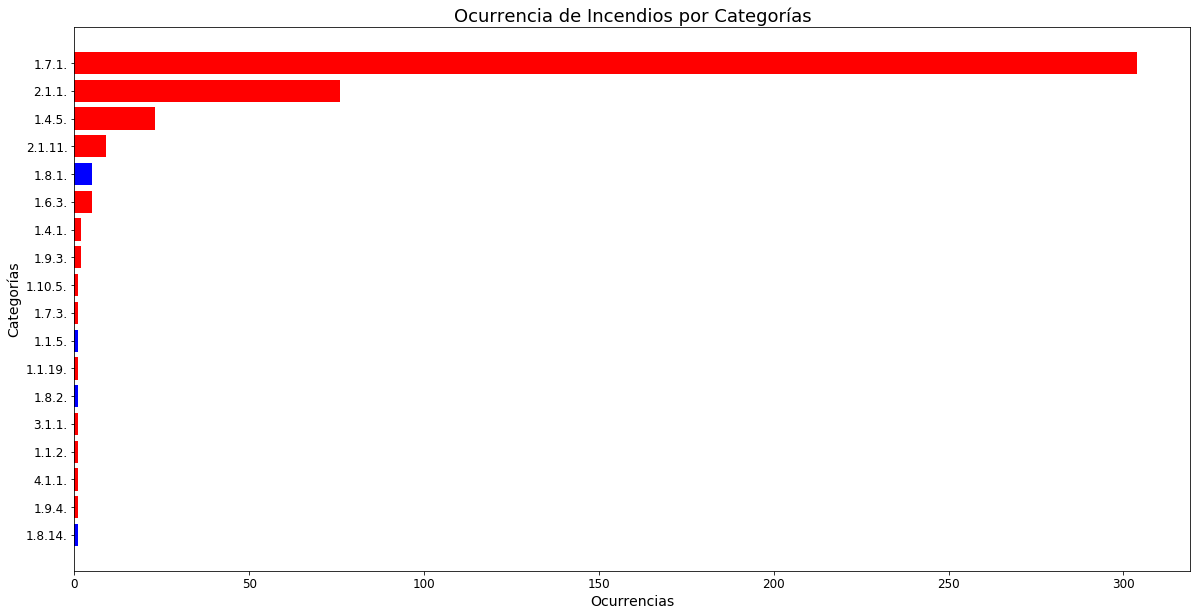

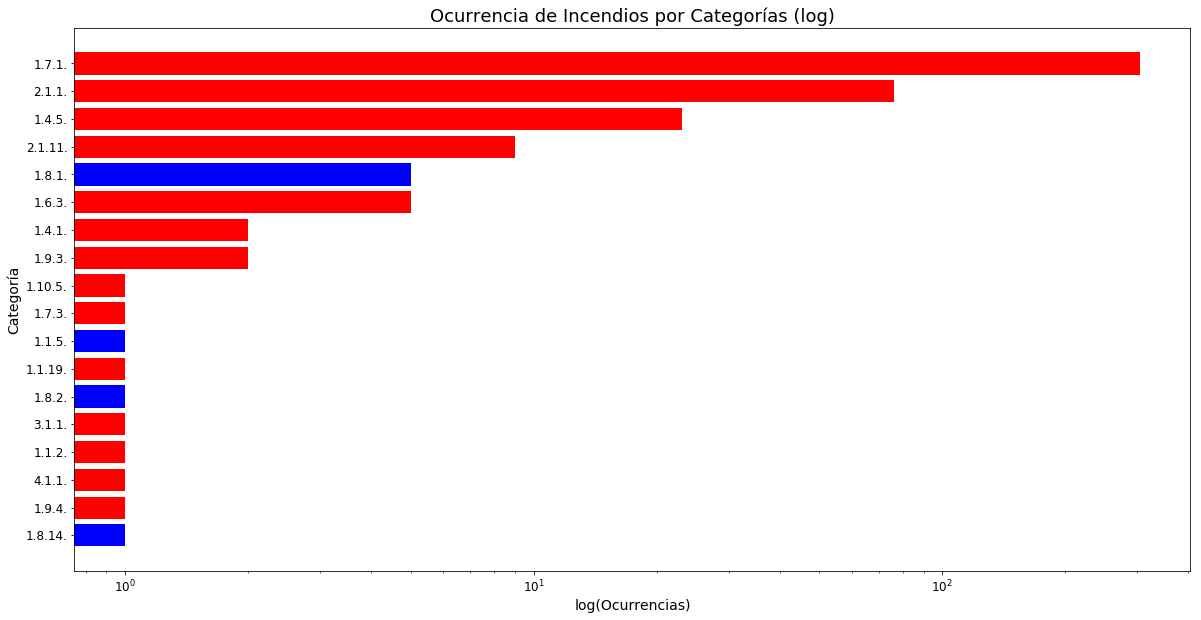

In [11]:
sorted_causes = sorted(causes.items(), key=lambda x: x[1])

x_cause = [cause_code(i[0]) for i in sorted_causes]
y_cause = [i[1] for i in sorted_causes] # occurrences
c_cause = ['blue' if cause_is_legal(c[0]) else 'red' for c in sorted_causes]

plot('Ocurrencia de Incendios por Categorías',
    'Ocurrencias',
    'Categorías',
    plt.barh,
        x_cause,
        y_cause,
        color=c_cause)

plot('Ocurrencia de Incendios por Categorías (log)',
    'log(Ocurrencias)',
    'Categoría',
    plt.barh,
        x_cause,
        y_cause,
        color=c_cause,
        log=True)

In [12]:
print(f"La causa legal 1.8.1. ha ocurrido {cause_by_code(causes, '1.8.1')} veces")

La causa legal 1.8.1. ha ocurrido 5 veces


Se buscan lluvias continuas

In [13]:
class Rain:
    def __init__(self, start, end, mm):
        self.start = start
        self.end = end
        self.mm = mm
    
    def __repr__(self):
        duration = int((self.end - self.start).total_seconds() / 3600)
        return f'{self.start} +{str(duration).zfill(2)}h {self.mm:.2f}mm'

class RainBuilder:
    def __init__(self):
        self.start = None
        self.mm = 0
    
    def is_started(self):
        '''
        Is a rain being registered
        '''
        return self.start is not None
    
    def set_start(self, start):
        '''
        Begin rain registry
        '''
        self.start = start
    
    def add_mm(self, mm):
        '''
        Add precipitation value to current rain
        '''
        self.mm += mm
    
    def commit(self, end):
        '''
        Create rain with collected data
        '''
        return Rain(self.start, end, self.mm)
        
# current rain being registered
rain_builder = RainBuilder()

# rain history
rains = []

# for each document (d) in dataset
for d in dataset:

    # check if precipitation timestamp == document timestamp
    # meaning that it is a valid precipitation datum
    if d['prc_ts'] == d['ts']:

        # if there is precipitation in d['ts']
        if d['prc'] > 0:

            # check if a rain is currently being registered
            if not rain_builder.is_started():
                rain_builder.set_start(d['ts'])

            # add rainfall to current rain
            rain_builder.add_mm(d['prc'])
        
        # if there is no precipitation
        else:

            # end current precipitation if there is one being registered
            if rain_builder.is_started():
                rains.append(rain_builder.commit(d['ts']))
                
                # new rain
                rain_builder = RainBuilder()

In [14]:
def ilegal(wildfires):
    '''Returns iterator with ilegal wildfires'''
    for w in wildfires:
        if not cause_is_legal(w['cause']):
            yield w

def total_days(fr, to):
    return (to - fr).total_seconds() / 3600 / 24

def rain_vs_days1(wz):
    '''pueden haber varias lluvias asociadas al mismo incendio
    many21
    '''
    days_to_next_wildfire = []
    rainfall              = []

    for r in rains:
        for w in wz:
            if w['start'] > r.end:
                rainfall.append(r.mm)
                days_to_next_wildfire.append(total_days(r.end, w['start']))
                break
    
    return days_to_next_wildfire, rainfall

def rain_vs_days2(wz):
    '''exactamente 1 lluvia asociada a un incendio
    just1
    
    varios incendios pueden estar asociados a la misma lluvia
    '''
    days_to_next_wildfire = []
    rainfall              = []

    for w in wz:
        for r in reversed(rains):
            if r.end < w['start']:
                rainfall.append(r.mm)
                days_to_next_wildfire.append(total_days(r.end, w['start']))
                break
    
    return days_to_next_wildfire, rainfall

def rain_vs_days3(wz, thresh_days=3):
    '''En este caso se consideran varias lluvias previas
    a un incendio siempre y cuando la diferencia de día entre ellas
    no sea mayor a `thresh_days`.
    
    Importante: son consideradas las lluvias entre incendios
    (no overlap)
    
    thresh
    '''
    days_to_next_wildfire = []
    rainfall              = []
    
    rains_fr = rains[0].start
    
    for w in wz:
        # reversed; so the first element is the rain right before wildfire
        rains_before_wildfire = reversed([r for r in rains if r.start >= rains_fr and r.end <= w['start']])
        rains_fr              = w['start']

        try:
            last = next(rains_before_wildfire)
        except StopIteration:
            # no rain before this wildfire
            continue

        last_start = last.start
        mm         = last.mm

        for r in rains_before_wildfire:
            if (last_start - r.end).total_seconds() / 3600 / 24 <= thresh_days:
                mm += r.mm
                last_start = r.start
            else:
                break
        
        days_to_next_wildfire.append(total_days(last.end, w['start']))
        rainfall.append(mm)
    
    return np.array(days_to_next_wildfire), np.array(rainfall)

def plt_rain_vs_days(title, wz, rain_vs_days=rain_vs_days1, plot_julios=False, **kwargs):
    '''deprecated in favor of plot_rain_vs_days'''
    x, y = rain_vs_days(wz, **kwargs)
    plt.title(title)
    plt.scatter(x, y)
    plt.xlabel('days_to_next_wildfire')
    plt.ylabel('rainfaill (mm)')
    if plot_julios:
        X = np.linspace(0, max(x))
        
        def julios(x):
            return 70-12.35545*x+0.52528*x*x
        
        def fit2(_x):
            coefs = np.polyfit(x, y, 2)
            return _x*_x*coefs[0]+_x*coefs[1]+coefs[2]
        
        def fitl(_x):
            # https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
            coefs = np.polyfit(np.log(x), y, 1)
            return coefs[0]*np.log(_x) + coefs[1]
        
        def fitL(_x):
            coefs = op.curve_fit(lambda t,a,b: a*np.exp(b*t), x, y)[0]
            return coefs[0]*np.exp(coefs[1]*_x)
        
        plt.plot(X, julios(X), 'r')
        #plt.plot(X, fit2(X), 'g')
        #plt.plot(X, fitl(X))
        plt.plot(X, fitL(X), 'g')
        
        
    plt.show()

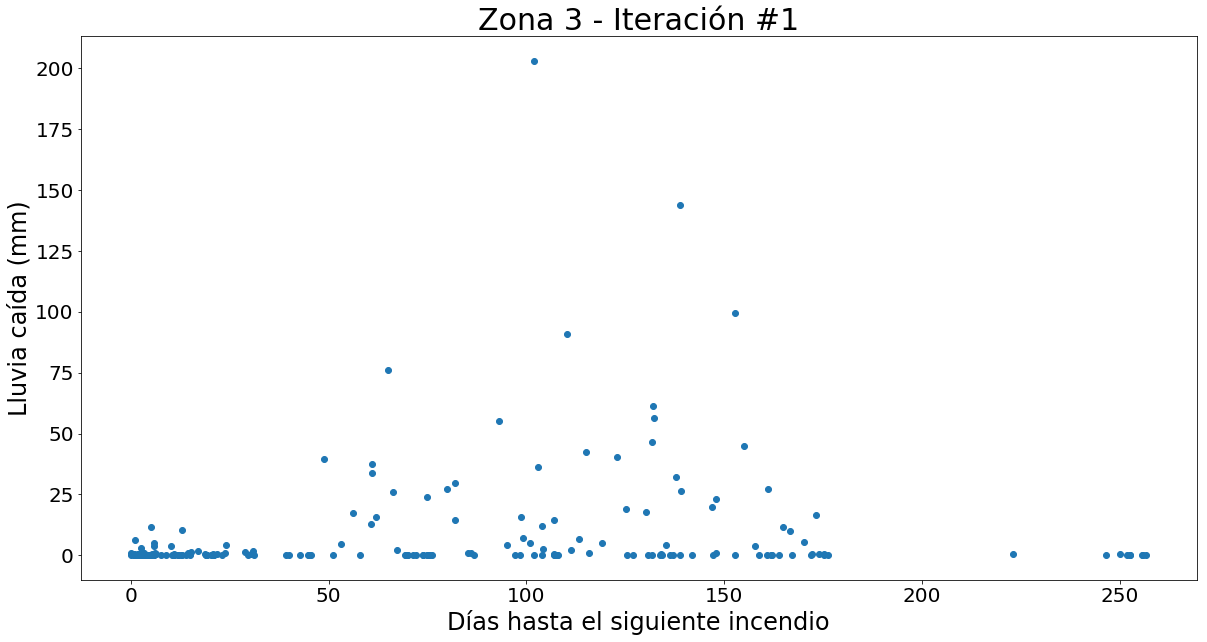

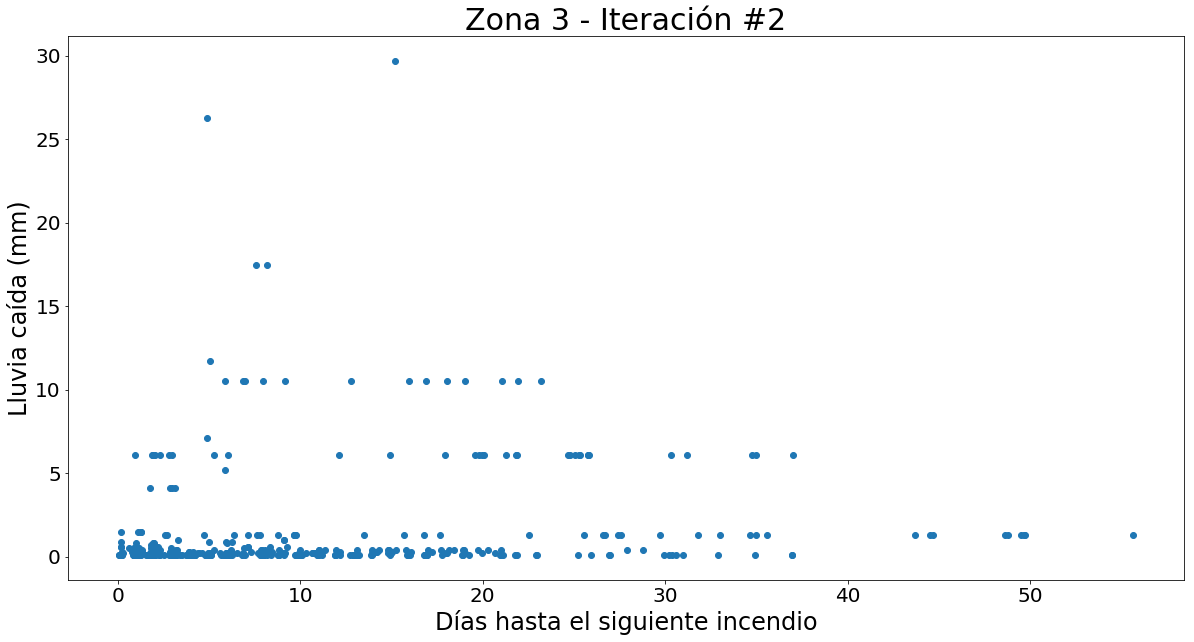

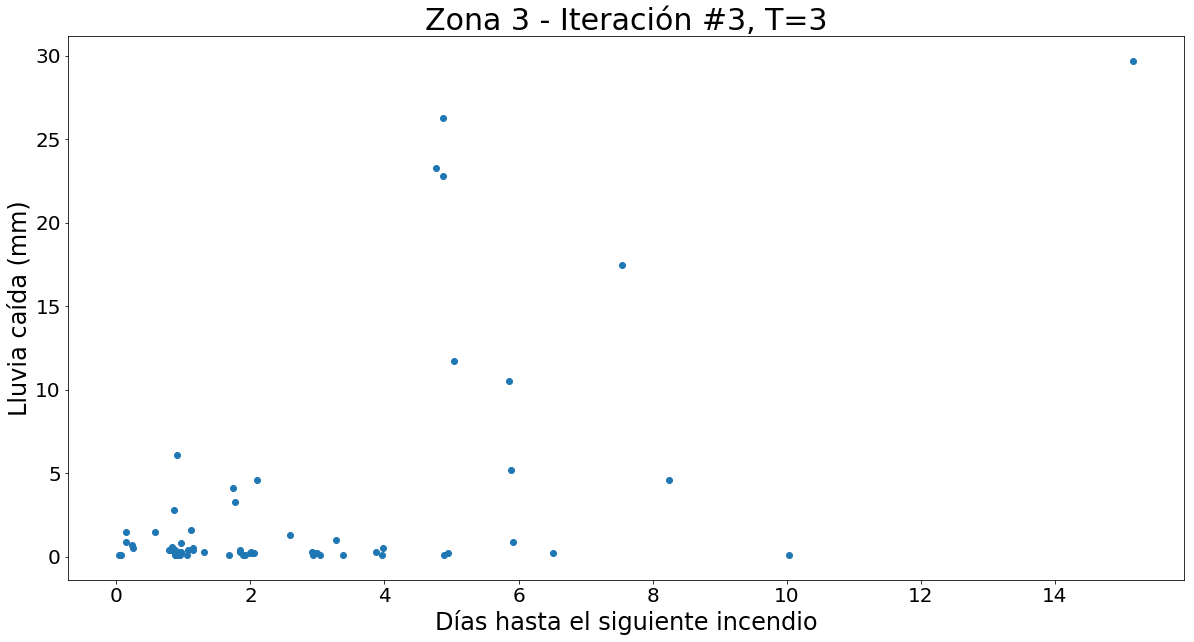

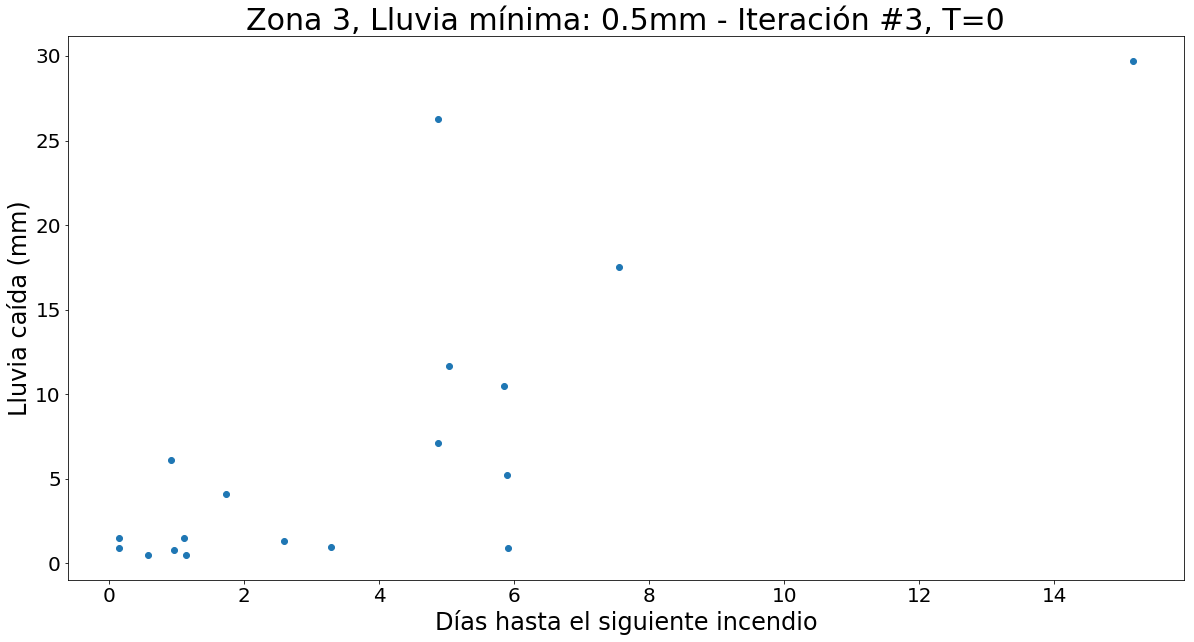

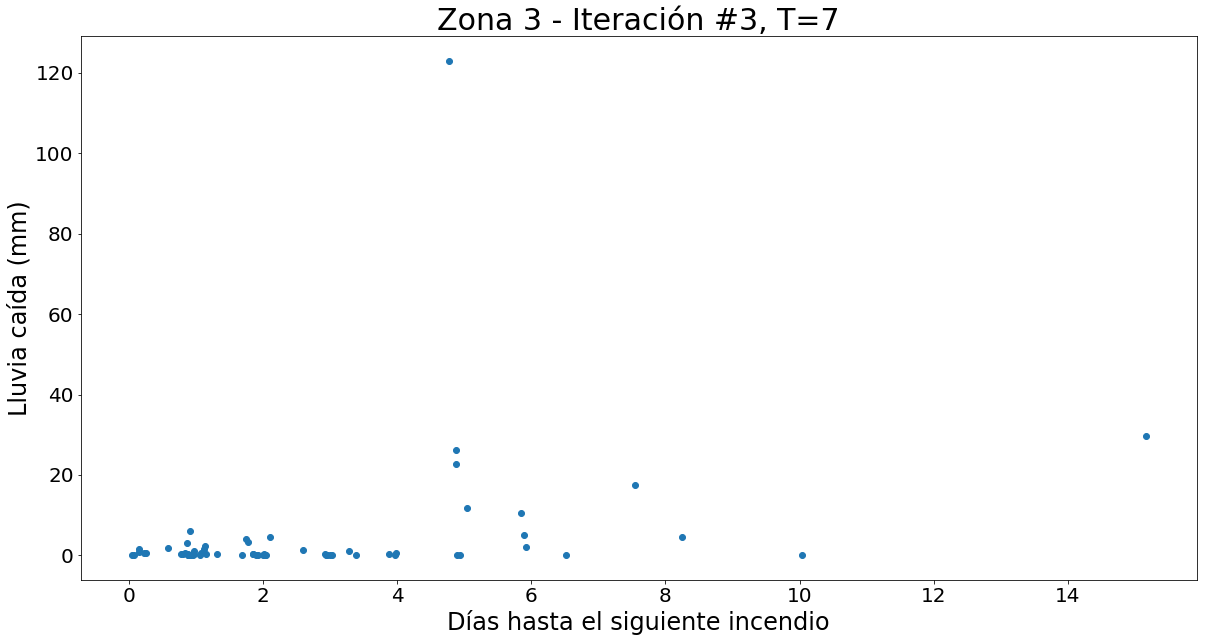

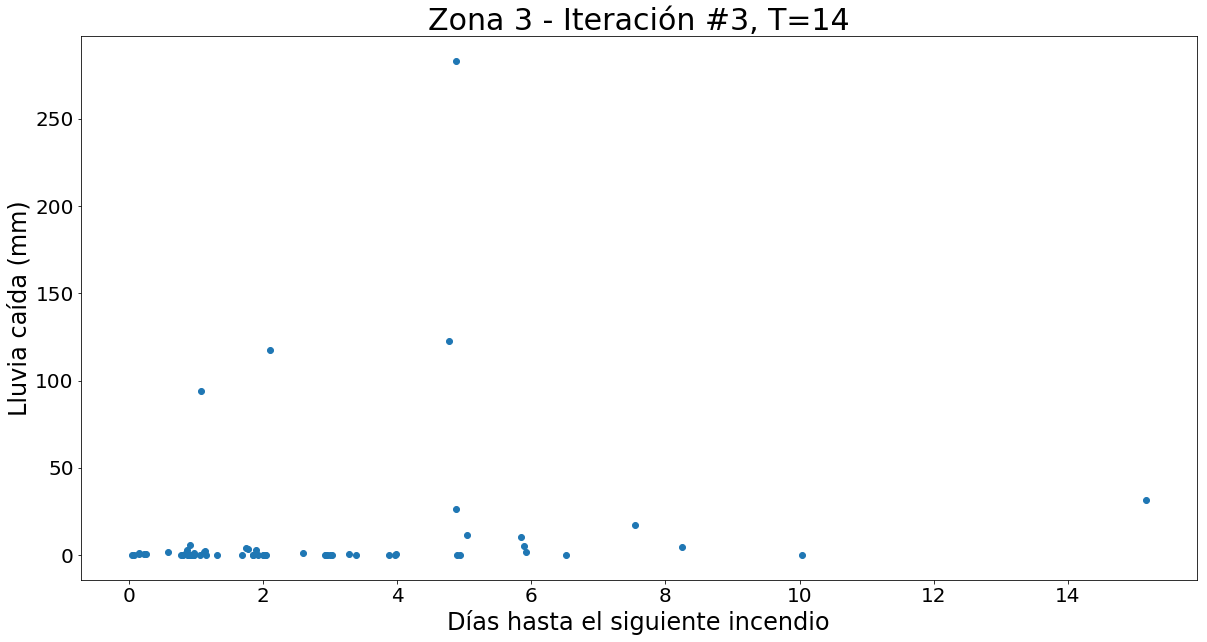

In [26]:
def julios(days, rainfall, x):
    '''Julio's original fit
    days and rainfall are ignored (compatibility)
    ''' 
    return 70-12.35545*x+0.52528*x*x, 'r'

def fit1(days, rainfall, x):
    coefs = np.polyfit(days, rainfall, 1)
    return x*coefs[0]+coefs[1], 'purple'

def fit2(days, rainfall, x):
    coefs = np.polyfit(days, rainfall, 2)
    return x*x*coefs[0]+x*coefs[1]+coefs[2], 'b'

def fitl(days, rainfall, x):
    # https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly
    coefs = np.polyfit(np.log(days), rainfall, 1)
    return coefs[0]*np.log(x) + coefs[1], 'b'

def fitL(days, rainfall, x):
    coefs = op.curve_fit(lambda t,a,b: a*np.exp(b*t), days, rainfall)[0]
    return coefs[0]*np.exp(coefs[1]*x), 'g'

def fancy_title(method, *, for_save=False):
    '''method guaranteed to be correct'''
    if method.lower() == 'many21':
        if for_save:
            return 'iter1'
        return 'Iteración #1'
    elif method.lower() == 'just1':
        if for_save:
            return 'iter2'
        return 'Iteración #2'
    else: # method threshN
        thresh = int(method[6:])
        if for_save:
            return f'iter3-t{thresh}'
        return f'Iteración #3, T={thresh}'
        

def plot_rain_vs_days(title, wildfires, method, min_mm, *fits):
    if method.lower() == 'many21':
        rain_vs_days = rain_vs_days1
    elif method.lower() == 'just1':
        rain_vs_days = rain_vs_days2
    elif method.lower().startswith('thresh'):
        try:
            thresh = int(method[6:])
        except ValueError:
            raise RuntimeError(f'Invalid Method: {method}')
        def rain_vs_days(wildfires):
            return rain_vs_days3(wildfires, thresh)
    else:
        raise RuntimeError(f'Invalid Method: {method}')
    
    days, rainfall = rain_vs_days(wildfires)
    filtered = [(d, r) for d, r in zip(days, rainfall) if r >= min_mm]
    days = [d for d, _ in filtered]
    rainfall = [r for _, r in filtered]
    
    def plot_fn():
        if len(fits) > 0:
            x = np.linspace(0, max(days))
            for fit in fits:
                plt.plot(x, *fit(days, rainfall, x))
        plt.scatter(days, rainfall)
    
    # hardcode zone 3 in filename
    min_title = ''
    if min_mm > 0:
        min_title = f'-min{str(min_mm).replace(".", "")}'
    plot(f'rainfall-days-zone3-{fancy_title(method, for_save=True)}{min_title}',
        f'{title} - {fancy_title(method)}',
        'Días hasta el siguiente incendio',
        'Lluvia caída (mm)',
        plot_fn)

plot_rain_vs_days('Zona 3', ilegal(wz3), 'many21', min_mm=0)
plot_rain_vs_days('Zona 3', ilegal(wz3), 'just1', min_mm=0)
plot_rain_vs_days('Zona 3', ilegal(wz3), 'thresh3', min_mm=0)
plot_rain_vs_days('Zona 3, Lluvia mínima: 0.5mm', ilegal(wz3), 'thresh0', 0.5)
plot_rain_vs_days('Zona 3', ilegal(wz3), 'thresh7', min_mm=0)
plot_rain_vs_days('Zona 3', ilegal(wz3), 'thresh14', min_mm=0)

In [16]:
max_mm = max([r.mm for r in rains])
for r in rains:
    if r.mm == max_mm:
        print(r)
        break

2015-08-05 18:00:00 +120h 203.10mm
